In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline

In [2]:

dataMeta = pd.read_csv('Dataset/NFLX.csv', index_col=0)
dataMeta.index = pd.to_datetime(dataMeta.index)
dataMeta = dataMeta.loc['2012':]
test = dataMeta['Volume'].resample('M').sum()
dataMeta = dataMeta[['Open','High','Low','Close','Adj Close']].resample('M').mean()
dataMeta['Volume'] = test
dataMeta.index = pd.to_datetime(dataMeta.index)

dataMeta.replace(0, np.nan, inplace=True)
dataMeta = dataMeta.interpolate()
dataMeta["Volume"] = dataMeta["Volume"].astype(int)

#dataMeta = dataMeta['2020-01-01':'2020-12-31']
dataMeta

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-31,13.742286,14.301000,13.417000,13.964500,13.964500,1829322600
2012-02-29,17.148929,17.511357,16.792500,17.131500,17.131500,1002673700
2012-03-31,16.126883,16.467208,15.799351,16.143117,16.143117,814660700
2012-04-30,14.514286,14.752071,14.172500,14.412000,14.412000,842254000
2012-05-31,10.523247,10.746039,10.182987,10.426818,10.426818,788860800
...,...,...,...,...,...,...
2022-05-31,185.863333,190.790476,180.326191,186.449524,186.449524,251615800
2022-06-30,184.890953,189.522381,180.589524,184.847620,184.847620,192552700
2022-07-31,196.233501,202.329002,192.664500,199.089000,199.089000,270083700


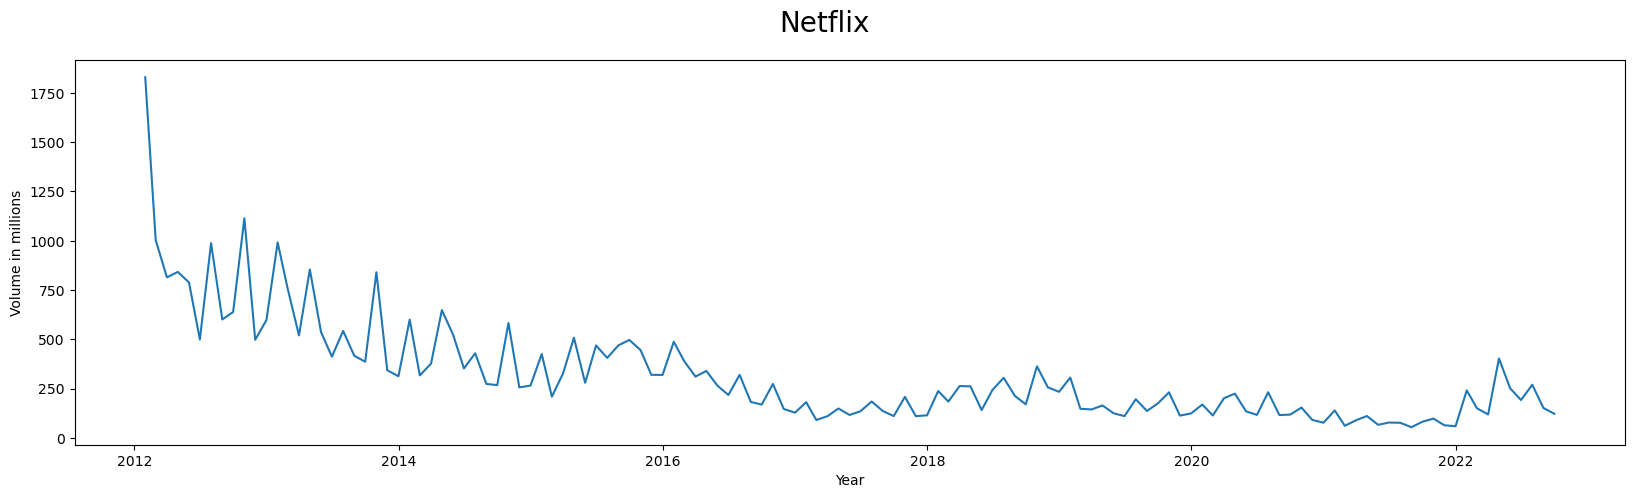

In [3]:
fig = plt.figure(figsize=(20,5))
ax = plt.gca()
fig.suptitle('Netflix', fontsize=20)
ax.set_xlabel('Year')
#ax.set_ylabel('Close')
#ax.ticklabel_format(useOffset=False, style='plain')
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel('Volume in millions')
plt.plot(dataMeta.index, dataMeta['Volume'])


In [4]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

In [5]:
test_stationarity(dataMeta['Volume'])

Test Statistic           -3.043209
p-value                   0.031052
Lags                     13.000000
Observations            115.000000
Critical Value (1%)      -3.488535
Critical Value (5%)      -2.887020
Critical Value (10%)     -2.580360
dtype: float64


In [6]:
# first difference
dataMeta['diff'] = dataMeta['Volume'] - dataMeta['Volume'].shift(1)  
test_stationarity(dataMeta['diff'].dropna(inplace=False))

#TODO: address warning 

Test Statistic           -3.497170
p-value                   0.008060
Lags                     13.000000
Observations            114.000000
Critical Value (1%)      -3.489058
Critical Value (5%)      -2.887246
Critical Value (10%)     -2.580481
dtype: float64


C:\Users\danie\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


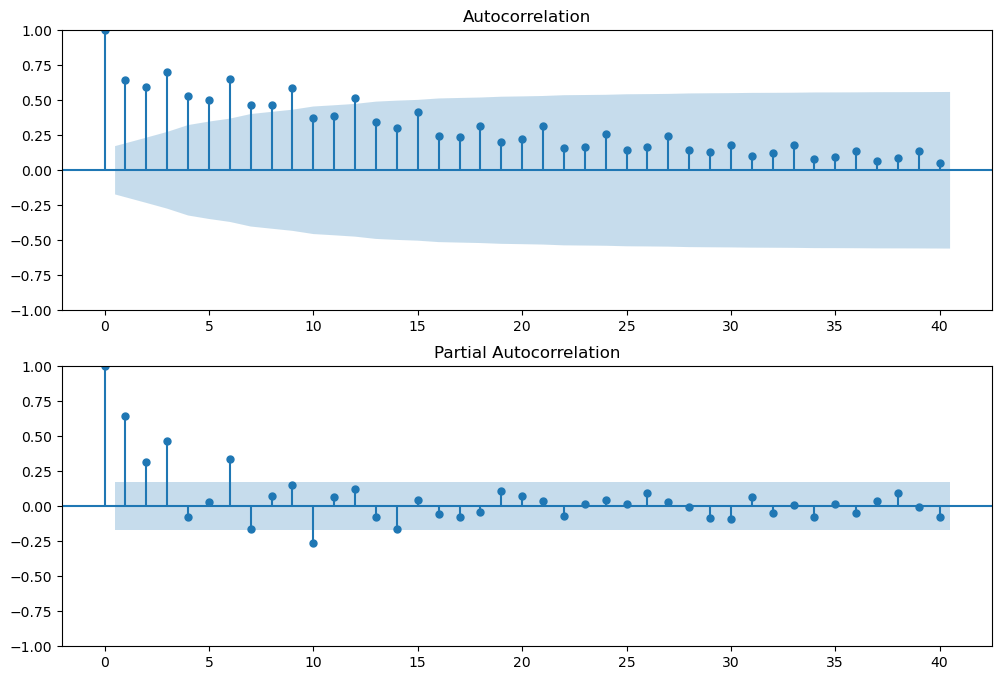

In [6]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataMeta['Volume'], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataMeta['Volume'], lags=40, ax=ax2)

C:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


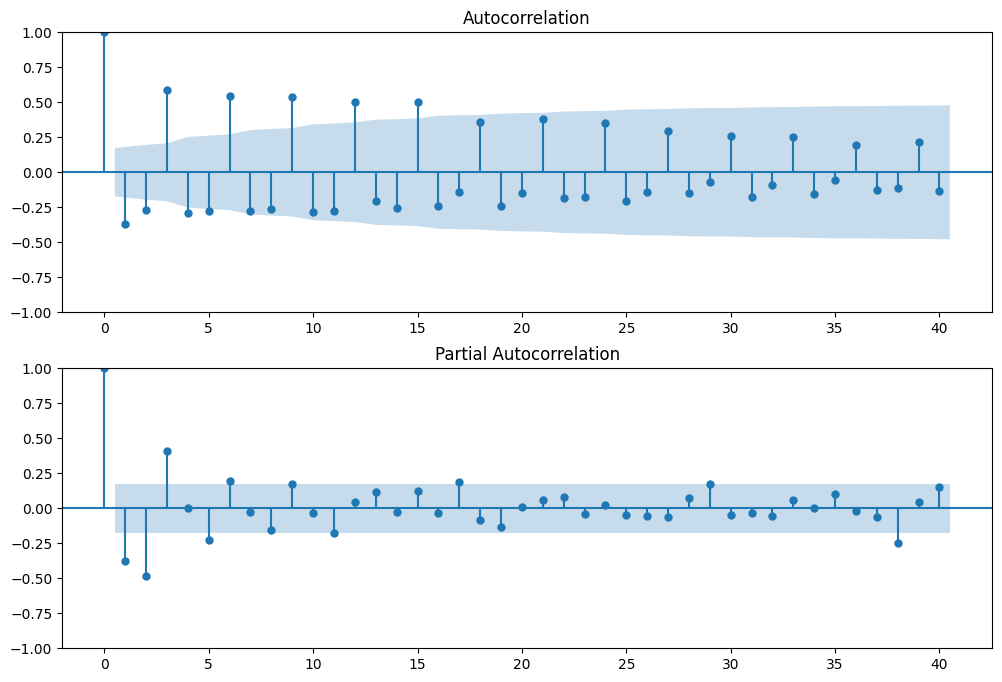

In [109]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataMeta['diff'][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataMeta['diff'][1:], lags=40, ax=ax2)

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  245
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -4946.112
Date:                Wed, 28 Dec 2022   AIC                           9900.224
Time:                        12:00:52   BIC                           9914.213
Sample:                    05-31-2002   HQIC                          9905.858
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6318      0.056    -11.381      0.000      -0.741      -0.523
ar.L2         -0.5525      0.033    -16.734      0.000      -0.617      -0.488
ma.L1          0.1101      0.065      1.701      0.0

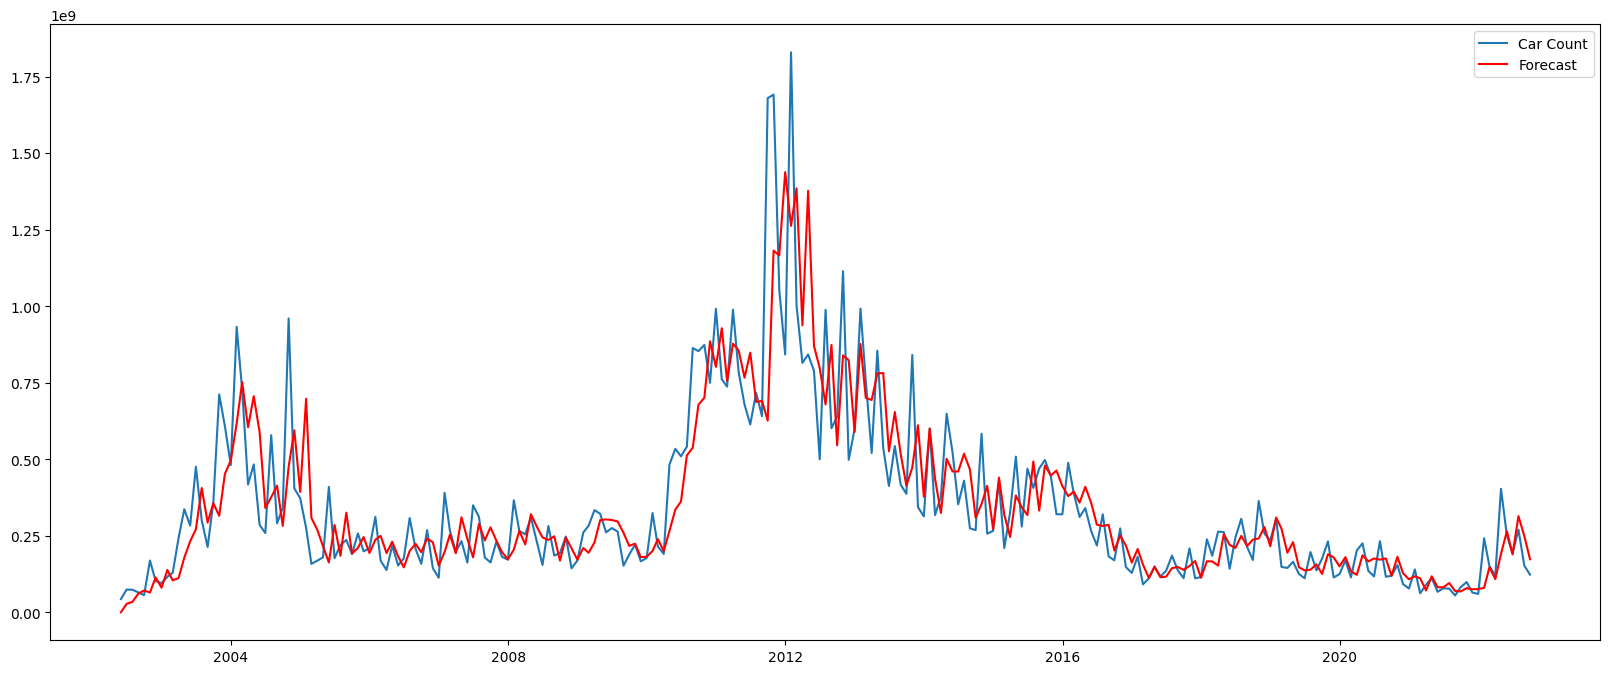

In [8]:
# # fit ARIMA model
# fig = plt.figure(figsize=(20,8))
# model = ARIMA(dataMeta['Volume'], order=(2,1,1)) 
# ax = plt.gca()
# results = model.fit() 
# plt.plot(dataMeta['Volume'])
# plt.plot(results.fittedvalues, color='red')
# ax.legend(['Car Count', 'Forecast'])

# print(results.summary())

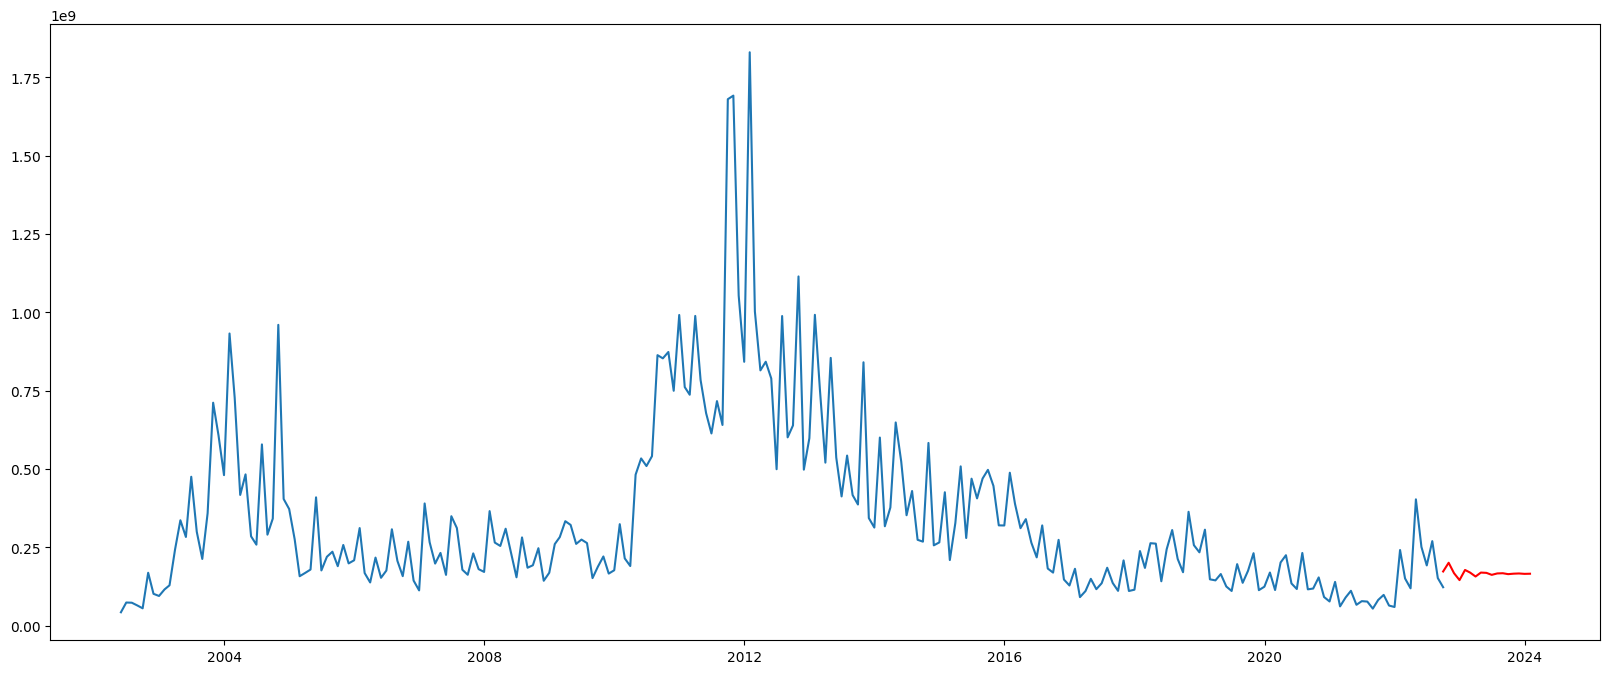

In [9]:
# # forecast quick and dirty
# # TODO: clean this up
# fig = plt.figure(figsize=(20,8))
# num_points = len(dataMeta['Volume'])
# x = results.predict(start=(244), end=(260), dynamic=False)

# plt.plot(dataMeta['Volume'])
# plt.plot(x, color='r')

<AxesSubplot: xlabel='Date'>

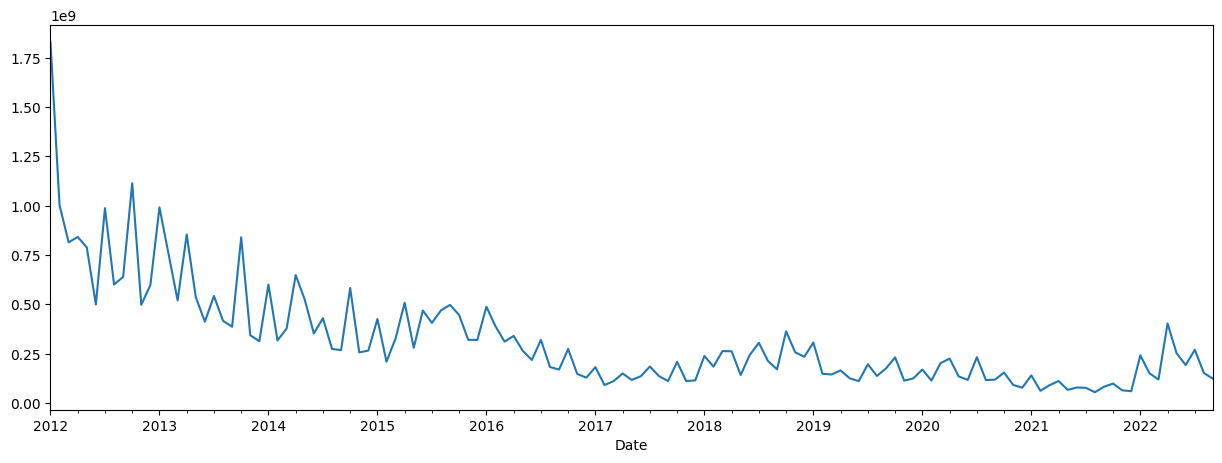

In [7]:
endog = dataMeta['Volume']
endog.plot(figsize=(15, 5))

In [11]:
# # Construct the model
# mod = sm.tsa.SARIMAX(endog, order=(2, 1, 1), trend='c')
# # Estimate the parameters
# res = mod.fit()

# print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  245
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -4946.107
Date:                Wed, 28 Dec 2022   AIC                           9902.214
Time:                        12:00:52   BIC                           9919.700
Sample:                    05-31-2002   HQIC                          9909.256
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.607e+05   8.78e-11   8.66e+15      0.000    7.61e+05    7.61e+05
ar.L1         -0.6318      0.055    -11.391      0.000      -0.741      -0.523
ar.L2         -0.5526      0.033    -16.738      0.0

In [12]:
# The default is to get a one-step-ahead forecast:
print(res.forecast())

2022-10-31    2.017498e+08
Freq: M, dtype: float64


In [13]:
# # Here we construct a more complete results object.
# fcast_res1 = res.get_forecast()

# # Most results are collected in the `summary_frame` attribute.
# # Here we specify that we want a confidence level of 90%
# print(fcast_res1.summary_frame(alpha=0.10))

Volume              mean       mean_se  mean_ci_lower  mean_ci_upper
2022-10-31  2.017498e+08  1.549898e+08  -5.318570e+07   4.566854e+08


In [14]:
# print(res.forecast(steps=2))

2022-10-31    2.017498e+08
2022-11-30    1.689236e+08
Freq: M, Name: predicted_mean, dtype: float64


In [15]:
# fcast_res2 = res.get_forecast(steps=2)
# # Note: since we did not specify the alpha parameter, the
# # confidence level is at the default, 95%
# print(fcast_res2.summary_frame())

Volume              mean       mean_se  mean_ci_lower  mean_ci_upper
2022-10-31  2.017498e+08  1.549898e+08  -1.020246e+08   5.055243e+08
2022-11-30  1.689236e+08  1.718027e+08  -1.678035e+08   5.056507e+08


In [16]:
# print(res.forecast('2023-06-30'))

2022-10-31    2.017498e+08
2022-11-30    1.689236e+08
2022-12-31    1.469117e+08
2023-01-31    1.797177e+08
2023-02-28    1.719144e+08
2023-03-31    1.594781e+08
2023-04-30    1.724078e+08
2023-05-31    1.718713e+08
2023-06-30    1.658265e+08
Freq: M, Name: predicted_mean, dtype: float64


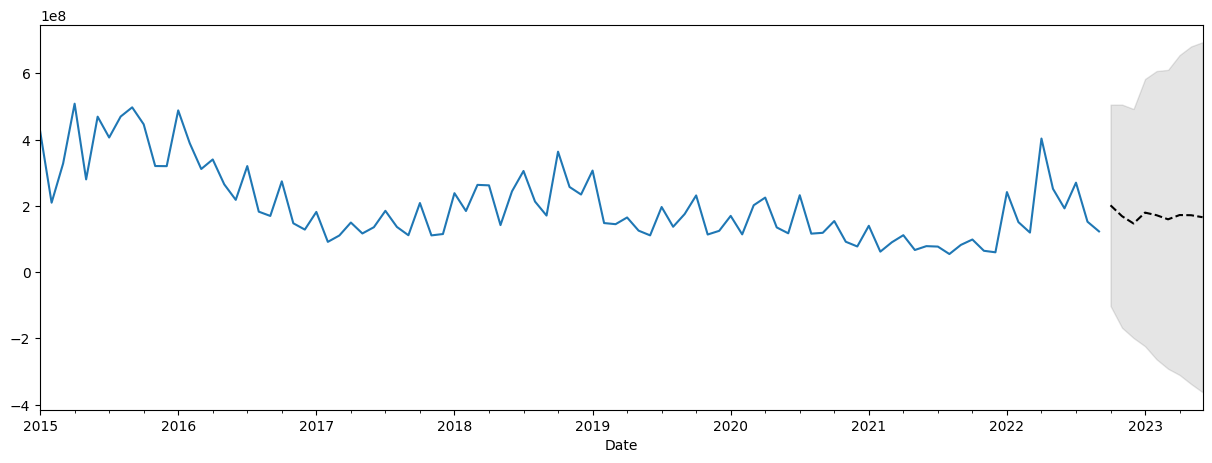

In [17]:
# fig, ax = plt.subplots(figsize=(15, 5))

# # Plot the data (here we are subsetting it to get a better look at the forecasts)
# # endog.loc['2015':].plot(ax=ax)

# # # Construct the forecasts
# # fcast = res.get_forecast('2023-06-30').summary_frame()
# # fcast['mean'].plot(ax=ax, style='k--')
# ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

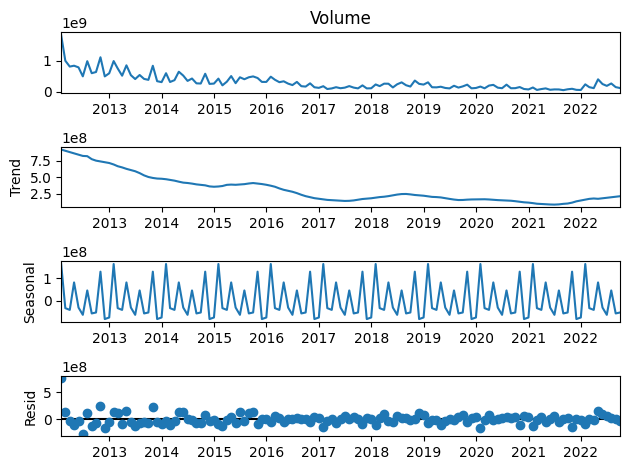

In [8]:
seasonal_decomp = seasonal_decompose(dataMeta["Volume"], model="additive",extrapolate_trend='freq')
seasonal_decomp.plot();

In [9]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [10]:
seasonal = seasonal_decomp.seasonal
check_stationarity(seasonal)

The series is stationary


C:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


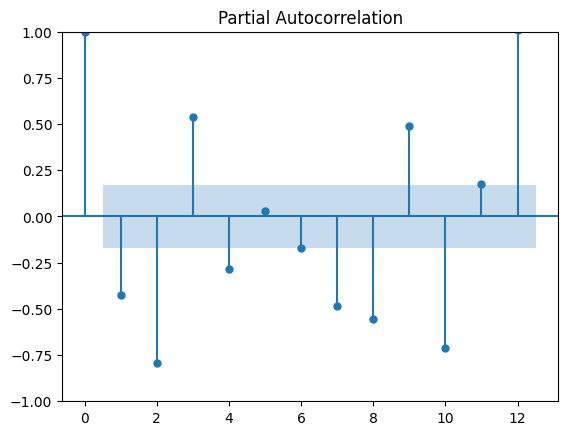

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal, lags =12)
plt.show()

In [5]:
import pmdarima as pm
model = pm.auto_arima(dataMeta['Volume'], p=3, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,             
                      d=0,
                      start_P=0,
                      max_P=5,
                      m=12,
                      seasonal=True,
                      dynamic=True,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=5245.717, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5372.962, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5228.608, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5285.760, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5486.987, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5281.650, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=5228.781, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5222.066, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5236.001, Time=0.05 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=5214.135, Time=0.12 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=5322.547, Time=0.08 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=5197.126, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[12] inte

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  129
Model:             SARIMAX(3, 0, 1)x(2, 0, [], 12)   Log Likelihood               -1994.063
Date:                             Fri, 30 Dec 2022   AIC                           4002.127
Time:                                     10:41:48   BIC                           4020.502
Sample:                                 01-31-2012   HQIC                          4009.568
                                      - 09-30-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0484      0.471      0.103      0.918      -0.874       0.971
ar.L2          0.3850      

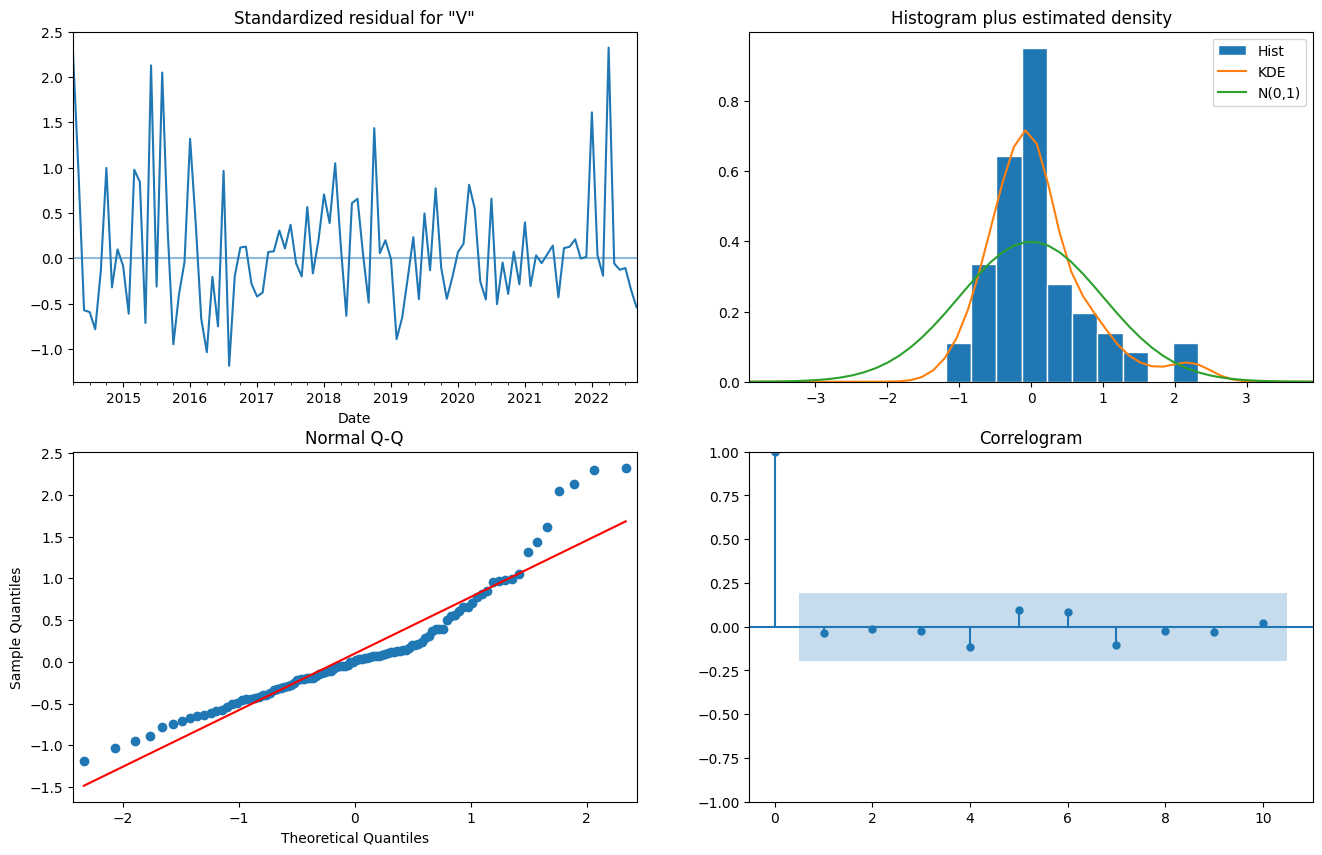

In [12]:
# Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(dataMeta['Volume'], 
                                    order=(3,0,1), 
                                    seasonal_order=(2,0,0,12), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='M')
                                    
# Fit the model
output = sarimax.fit()
    
# Print output summary
print(output.summary())

# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));

<AxesSubplot: xlabel='Date'>

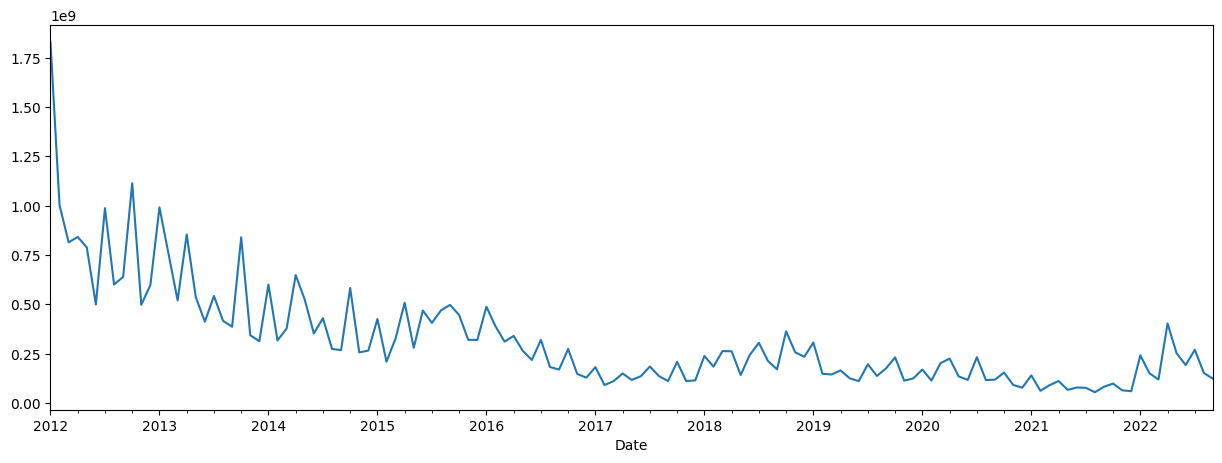

In [8]:
endog = dataMeta['Volume']#.loc['2012':]
endog.plot(figsize=(15, 5))

In [7]:
# Construct the model
mod = sm.tsa.statespace.SARIMAX(dataMeta['Volume'], 
                                    order=(3,0,0), 
                                    seasonal_order=(2,0,0,12), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='M')
# Estimate the parameters
res = mod.fit()

print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  129
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 12)   Log Likelihood               -1999.973
Date:                            Wed, 05 Apr 2023   AIC                           4011.947
Time:                                    12:08:54   BIC                           4027.697
Sample:                                01-31-2012   HQIC                          4018.325
                                     - 09-30-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5603      0.239      2.340      0.019       0.091       1.030
ar.L2          0.0990      0.267   

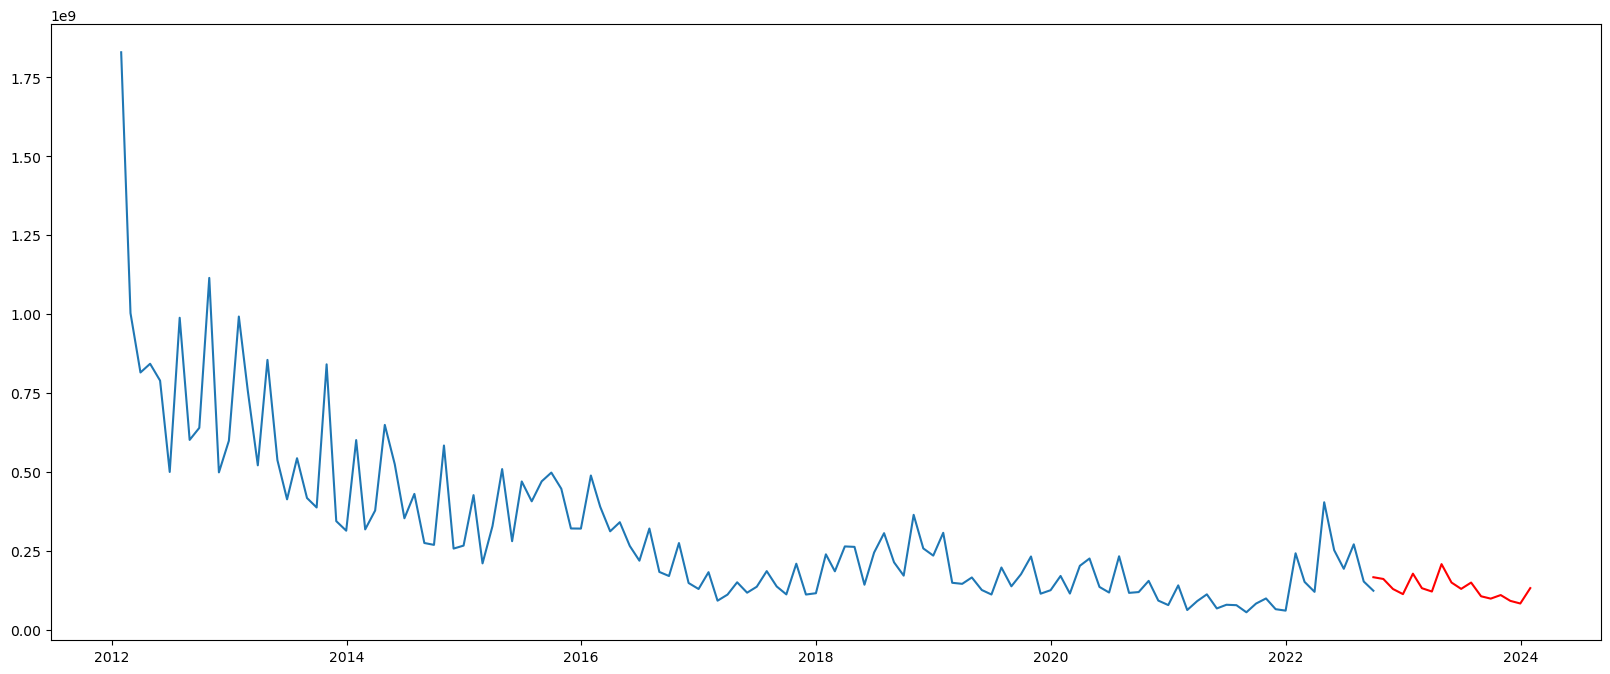

In [19]:
# forecast quick and dirty
# TODO: clean this up
fig = plt.figure(figsize=(20,8))
num_points = len(dataMeta['Volume'])
x = res.predict(start=(128), end=(144), dynamic=False)

plt.plot(dataMeta['Volume'])
plt.plot(x, color='r')

In [9]:
len(dataMeta['Volume'])

129

In [13]:
from statsmodels.tools.eval_measures import rmse
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/ np.abs(actual))
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    rmse = np.mean((forecast - actual)**2)**.5
    nrmse = rmse/(np.max(actual)-np.min(actual))
    return({'mape':mape,'me':me,'mae':mae,'mpe':mpe,'rmse':rmse,'nrmse':nrmse})

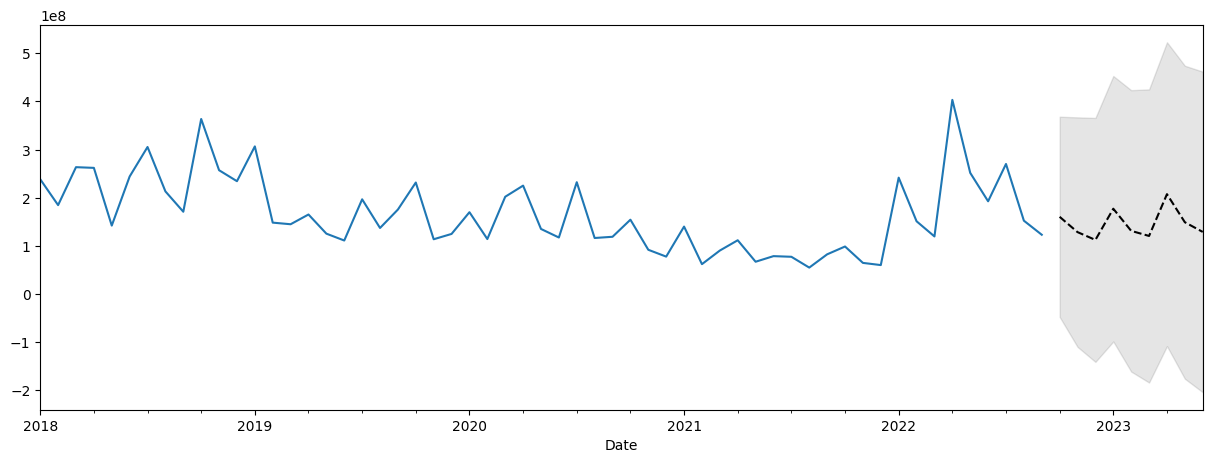

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
endog.loc['2018':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast('2023-06-30').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

In [18]:
# Step 1: fit model parameters w/ training sample
training_obs = int(len(endog) * 0.8)

training_endog = endog[:training_obs]
training_mod = sm.tsa.statespace.SARIMAX(training_endog, 
                                    order=(3,0,0), 
                                    seasonal_order=(2,0,0,12), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='M')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

ar.L1       6.166955e-01
ar.L2       1.017154e-01
ar.L3       1.618145e-01
ar.S.L12    3.237313e-01
ar.S.L24    1.766738e-01
sigma2      1.319811e+16
dtype: float64


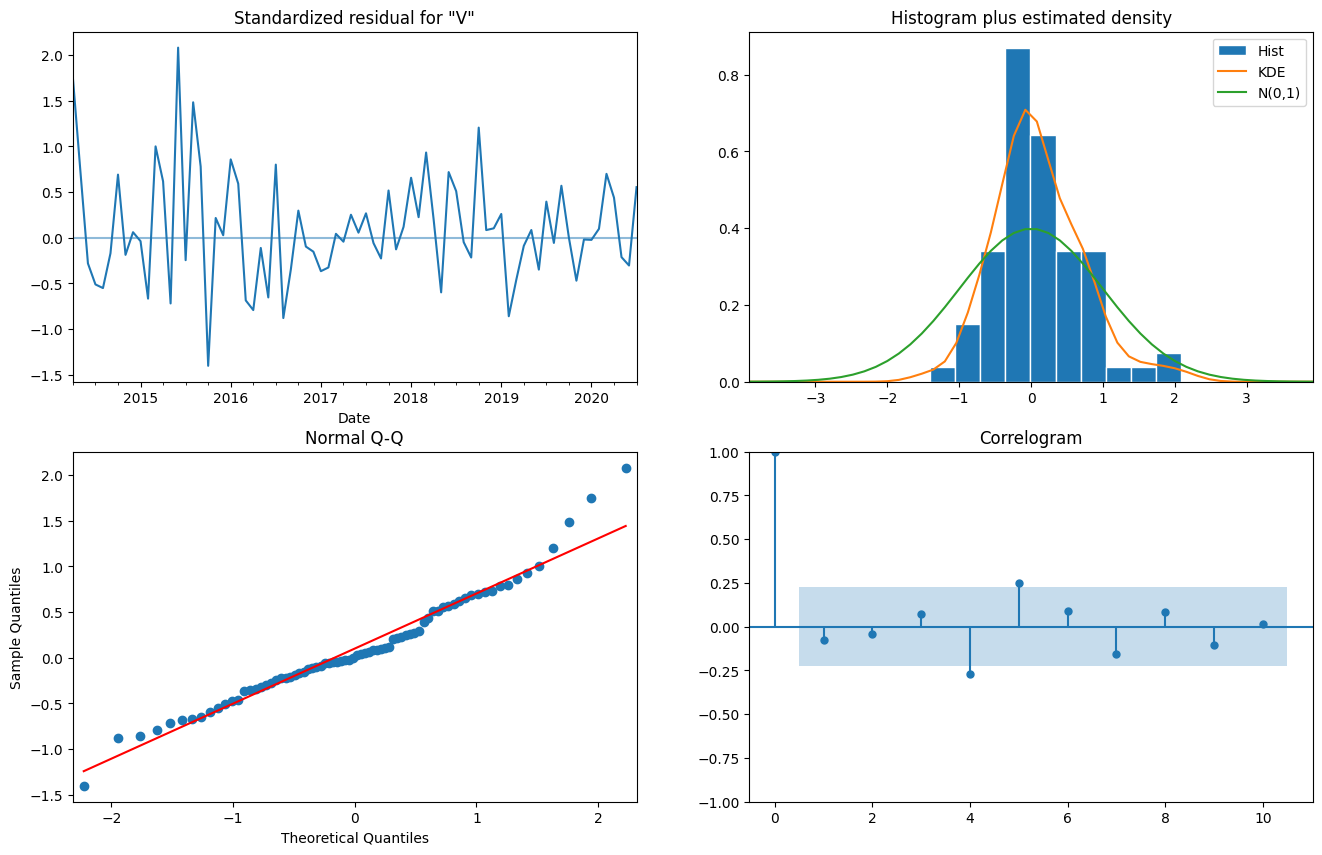

In [35]:
training_res.plot_diagnostics(figsize=(16,10));

In [19]:
forecast_accuracy(training_res.forecast('2022-09-30'),dataMeta['Volume']['2020-08-31':])

{'mape': 0.5172804775071107,
 'me': -16860191.234377876,
 'mae': 71282210.10901056,
 'mpe': 0.1369858980980398,
 'rmse': 95315886.5374028,
 'nrmse': 0.27344229575616225}

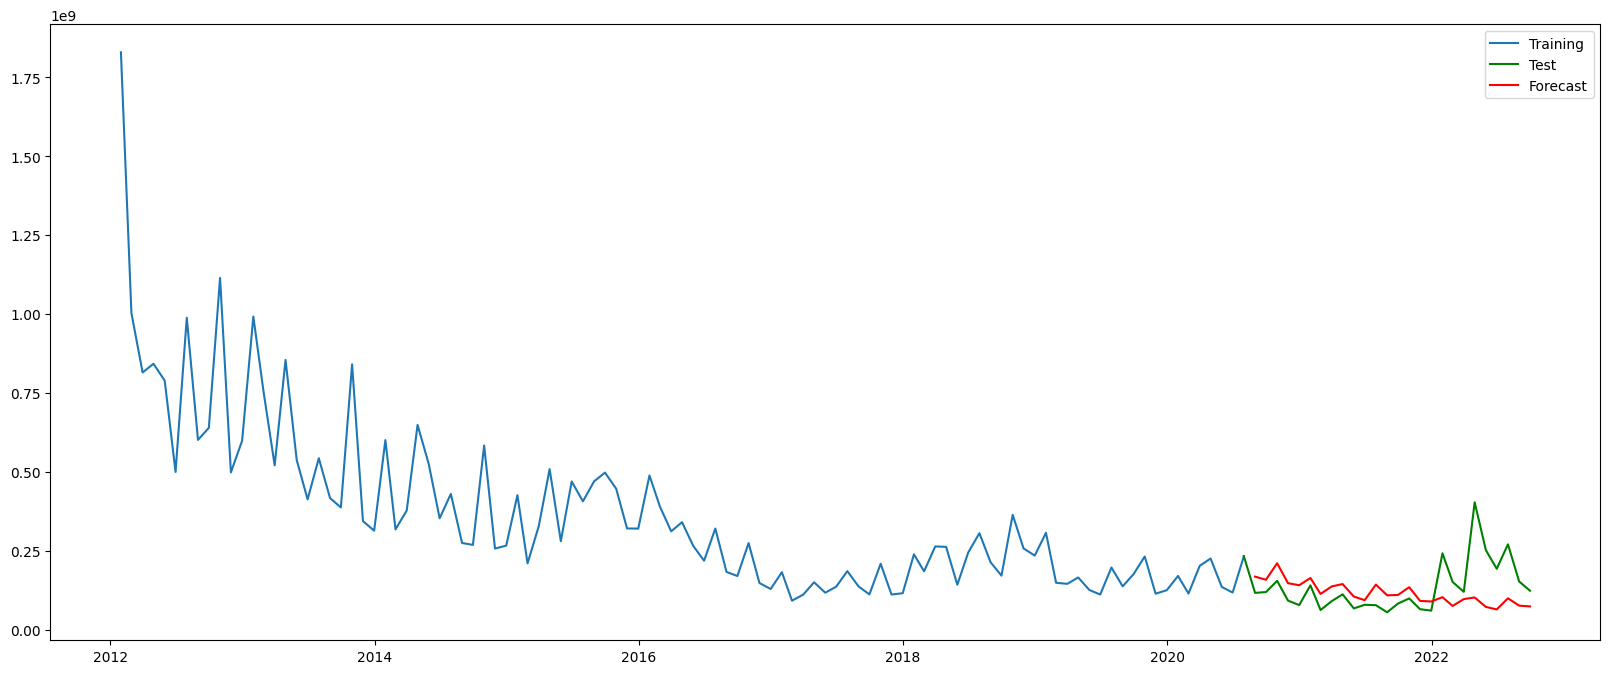

In [20]:

fig = plt.figure(figsize=(20,8))
ax = plt.gca()

plt.plot(training_endog)
plt.plot(dataMeta['Volume'].loc['2020-07-31':], color='green')
plt.plot(training_res.forecast('2022-09-30'), color='red')
ax.legend(['Training', 'Test','Forecast'])

#results.summary()

In [21]:
training_res.forecast()

2020-08-31    1.678118e+08
Freq: M, dtype: float64

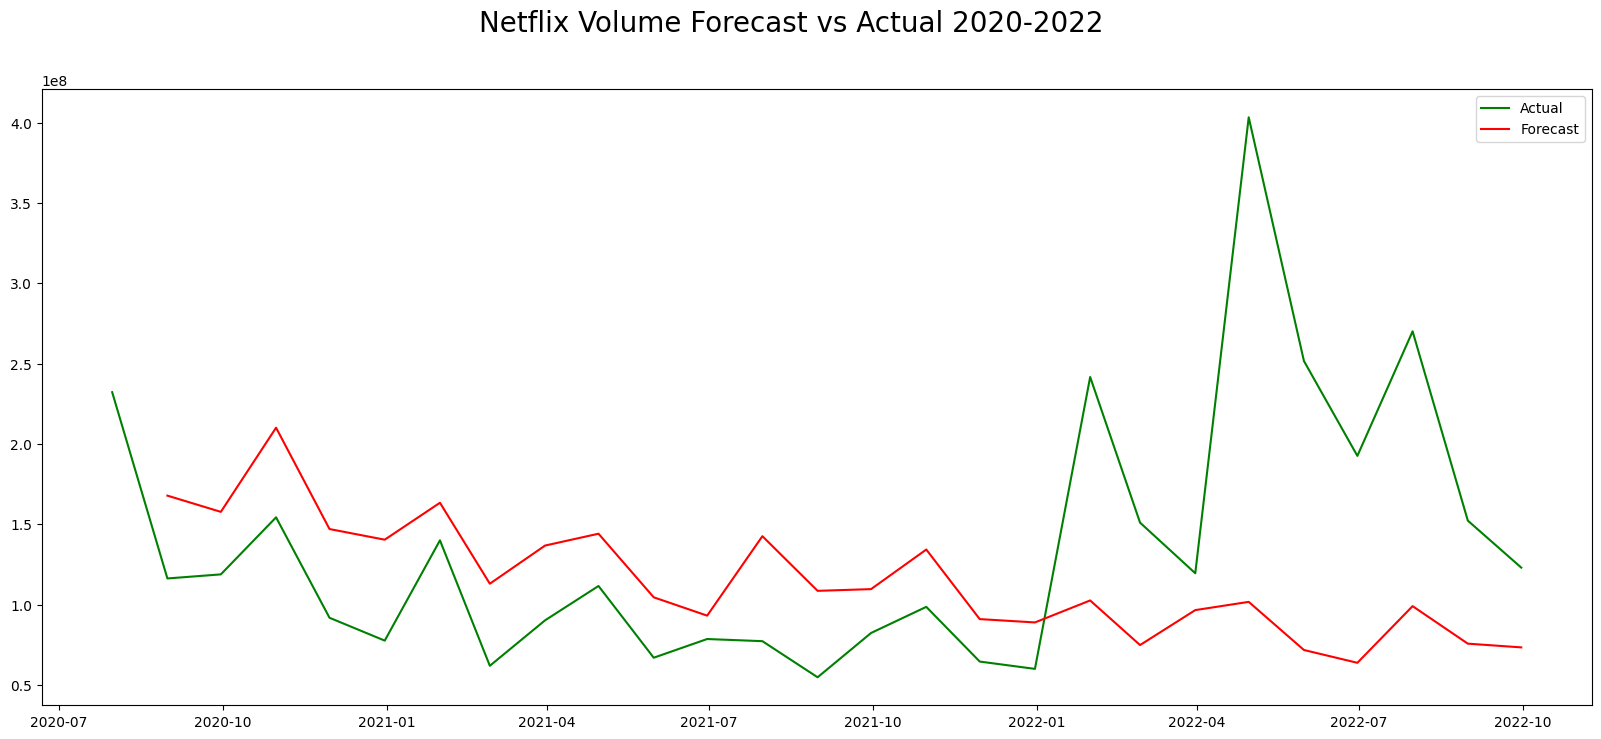

In [28]:

fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.suptitle('Netflix Volume Forecast vs Actual 2020-2022', fontsize=20)
plt.plot(dataMeta['Volume'].loc['2020-07-31':], color='green')
plt.plot(training_res.forecast('2022-09-30'), color='red')
ax.legend(['Actual', 'Forecast'])

#results.summary()

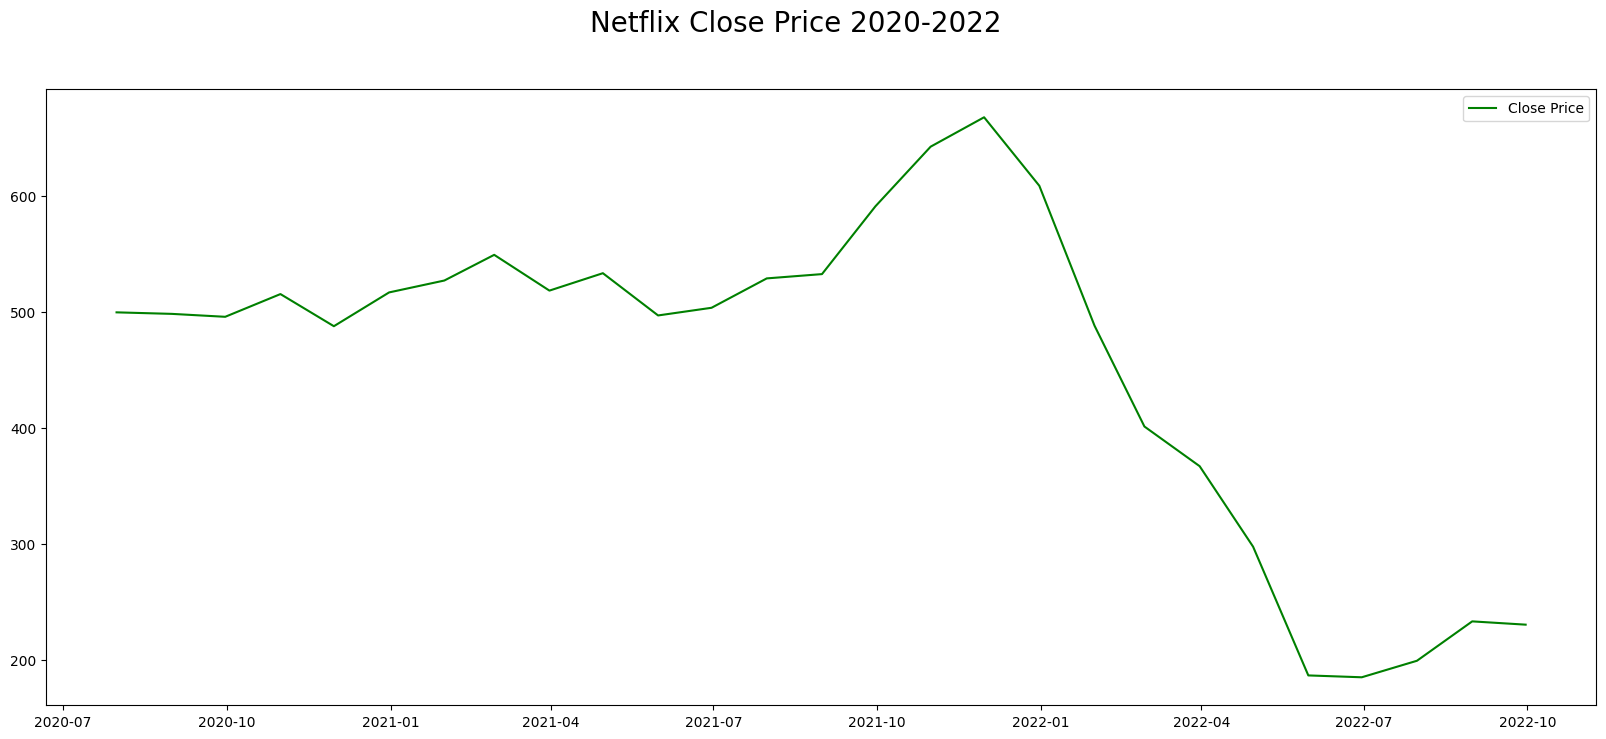

In [27]:

fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.suptitle('Netflix Close Price 2020-2022', fontsize=20)
plt.plot(dataMeta['Close'].loc['2020-07-31':], color='green')

ax.legend(['Close Price'])

#results.summary()